# Проект по анализу данных с сайта Новости ООН

## Часть 1. Сбор данных

### Реализация парсера

In [ ]:
import re
import time
import datetime
import pandas as pd
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup

!pip install selenium
from selenium import webdriver
from dataclasses import dataclass
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00


In [ ]:
SLEEP = 1
# MAX_DEPTH_TOPIC = [462, 67, 578, 576, 309, 344, 944, 1632, 878, 82, 372]
DEPTH = 309
BASE_URL = "https://news.un.org/ru/news"
TOPIC = [
    "humanitarian-aid",  #'migrants-and-refugees',
    "women",
    "health",
    "climate-change",
    "culture-and-education",
    "law-and-crime-prevention",
    "peace-and-security",
    "un-affairs",
    "human-rights",  #'sdgs',
    "economic-development",
]
HOW_G = "/topic/"

In [ ]:
# Извлечение данных со страницы
def get_page(page, element):
    info = []
    response = requests.get(BASE_URL + HOW_G + element + f"?page={page}")
    soup = BeautifulSoup(response.content, "html.parser")
    articles = soup.find_all("article", {"role": "article"})
    # Извлечение заголовка для одной статьи
    for ar in articles:
        title = ar.find(
            "span",
            {"class": "field field--name-title field--type-string field--label-hidden"},
        ).text
        # Извлечение даты публикации для одной статьи
        date = ar.find("time").get("datetime")[:10]
        # Извлечение ссылки для одной статьи
        link = BASE_URL[:-8] + ar.find("a").get("href")
        # Извлечение вступительного текста одной статьи
        response_one = requests.get(link)
        soup_one = BeautifulSoup(response_one.content, "html.parser")
        abstract = soup_one.find(
            "div", {"class": "views-field views-field-field-news-story-lead"}
        ).text
        # Извлечение полного текста одной статьи (без заголовков, источников, таблиц)
        try:
            text = ""
            text_list = soup_one.find(
                "div",
                {
                    "class": "clearfix text-formatted field field--name-field-text-column field--type-text-long field--label-hidden field__item"
                },
            ).find_all(
                [
                    "p",
                    "h2",
                    "h3",  # Добавление в текст заголовков и подзаголовков самого текста
                ]
            )
            for i in text_list:
                text += i.text + "\n"
        except AttributeError:
            text = None
        time.sleep(SLEEP)

        row = {
            "url": link,
            "title": title,
            "date": date,
            "abstract": abstract,
            "text": text,
            "topics": element,
        }
        info.append(row)
    time.sleep(SLEEP)
    return info

In [ ]:
# Сбор данных с сайта по рубрикам
infa = []
for element in TOPIC:  # заменить TOPIC на REGION, если нужно парсить по регионам
    print(element)
    pages = range(DEPTH)
    for page in tqdm(pages):
        infa.extend(get_page(page, element))
        time.sleep(SLEEP)

In [ ]:
df = pd.DataFrame(infa)
df.to_pickle("df_topics.p", compression="gzip")

Опытным путем было выяснено, что у некоторых статей отсутствует полный текст. Их придется удалить.

In [ ]:
# Выводим строки со значение текста None
df[df["text"].isna()]

,url,title,date,abstract,text,topics
10035,https://news.un.org/ru/interview/2019/09/1362682,Поступки каждого человека имеют последствия дл...,2019-09-10,В штаб-квартире ООН в Нью-Йорке сегодня не най...,None,climate-change
26807,https://news.un.org/ru/story/2018/02/1322941,Вооруженные группы в Южном Судане выпустили 30...,2018-02-07,"Вооруженные группы, действующие в Южном Судане...",None,human-rights


In [ ]:
# Изначальнаф форма датасета
df.shape

(30900, 6)

In [ ]:
# Удаляем статьи со None
df = df.dropna()

In [ ]:
# Форма датасета
df.shape

(30898, 6)

В итоге мы удалили 2 статьи, у которых отсутствует полный текст.

Теперь проверим, есть ли дупликаты.

In [ ]:
duplicateRows = df[df.duplicated(["url"])]
duplicateRows

,url,title,date,abstract,text,topics
3119,https://news.un.org/ru/story/2023/06/1442232,Роза Отунбаева: вводимые талибами запреты край...,2023-06-21,"Запреты, вводимые Талибаном, в особенности те,...",ООН будет соблюдать принцип недискриминации\n«...,women
3139,https://news.un.org/ru/story/2023/04/1440472,Афганистан: Совет Безопасности единодушно осуд...,2023-04-28,В своей исторической резолюции Совет Безопасно...,"Резолюция, принятая единогласно, призывает к «...",women
3146,https://news.un.org/ru/story/2023/04/1439587,Генсек ООН призвал талибов отменить решение о ...,2023-04-05,Генеральный секретарь ООН Антониу Гутерриш сам...,Миссия ООН в Афганистане получила от де-факто ...,women
3147,https://news.un.org/ru/story/2023/04/1439557,Де-факто власти Афганистана запретили местным ...,2023-04-04,Миссия ООН в Афганистане получила от де-факто ...,«Мы планируем провести завтра в Кабуле дополни...,women
3179,https://news.un.org/ru/story/2023/01/1436827,Делегация руководства ООН посетила Афганистан ...,2023-01-20,"Члены делегации ООН, возглавляемой Первым заме...","Четырехдневный визит \n\n\nКроме Мохаммед, в ...",women
...,...,...,...,...,...,...
30874,https://news.un.org/ru/story/2008/08/1130401,Пан Ги Мун отправился с поездкой в Европу,2008-08-27,Сегодня Генеральный секретарь Пан Ги Мун вылет...,31 августа в Женеве Пан Ги Мун выступит на се...,economic-development
30876,https://news.un.org/ru/story/2008/08/1130181,"В Вене прошел семинар, посвященный роли яд...",2008-08-25,В Вене под эгидой Продовольственной и сельск...,"Его участники подчеркивали, что применяемые в...",economic-development
30878,https://news.un.org/ru/story/2008/08/1130111,От последствий изменения климата больше всего ...,2008-08-22,Сегодня Управление ООН по координации гуманита...,Эксперты ООН совместно со своими партнерами из...,economic-development
30887,https://news.un.org/ru/story/2008/07/1128831,Для успешного решения продовольственного и эне...,2008-07-21,В эти дни Генеральная Ассамблея ООН обсуждает ...,В своем обращении к государствам-членам Срджян...,economic-development


Удалим повторы статей, при этом распределим их так, чтобы нанести наименьший ущерб сбаоансированности категорий.

In [ ]:
# Удаление повторяющихся статей с их распределением по наменее частотным рубрикам
for i in tqdm(df["url"][:]):
    coun = len(df[df["url"] == i])
    if coun > 1:
        topic = list(df["topics"][df["url"] == i])
        topic_in_df = df["topics"][df["url"] == i].index.values.astype(int)
        t = []
        for j in topic:
            t.append(len(df[df["topics"] == j]))
        tipic_max_ind = t.index(max(t))
        df.drop(labels=[topic_in_df[tipic_max_ind]], axis=0, inplace=True)

df.reset_index(drop=True, inplace=True)

  0%|          | 0/30898 [00:00<?, ?it/s]

In [ ]:
# Форма окончательного датасета
df.shape

(22065, 6)

Получается, мы удалили около 9000 статей-повторов.

### Первичный анализ данных

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Основные описательные статистики + визуальный анализ данных. Важно отметить интересные моменты в ваших данных до проведения исследования:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- отметить моменты, которые позволят до проведения расчетов и построения моделей, выдвинуть несколько гипотез/предположений о результатах следующих этапов и т.д.
---

- Распределение категорий
- Распределение времени новостей
- Распределение по длине заголовка
- Распределение по длине вступительного текста
- Распределение по длине основного текста
- Ключевые слова по каждой из тематик

In [ ]:
df = pd.read_pickle("df_topics.p", compression="gzip")

In [ ]:
# Форма датасета
df.shape

(22065, 6)

In [ ]:
df.head()

,url,title,date,abstract,text,topics,year,month,weekday,len_title,len_abstract,len_text,lifetime
1,https://news.un.org/ru/story/2023/10/1445952,Глава ООН в Каире призвал «к двум немедленным ...,2023-10-19,Находящийся с визитом в Каире Генеральный секр...,«Я нахожусь на Ближнем Востоке с гуманитарной ...,humanitarian-aid,2023,October,Thursday,69,323,1965,12332.0
2,https://news.un.org/ru/story/2023/10/1445942,Гуманитарная помощь готова к отправке в Газу,2023-10-19,Гуманитарные организации готовятся доставить в...,Визит главы ООН в Каир\nГенеральный секретарь ...,humanitarian-aid,2023,October,Thursday,44,306,2484,12332.0
3,https://news.un.org/ru/story/2023/10/1445922,Экстренное заседание Совбеза по Ближнему Восто...,2023-10-18,"«Я боюсь, что мы стоим на краю глубокой и опас...",Один из самых трудных моментов \nПо его словам...,humanitarian-aid,2023,October,Wednesday,80,329,7343,13772.0
4,https://news.un.org/ru/story/2023/10/1445907,Израиль-Газа: глава ООН призывает к прекращени...,2023-10-18,Глава ООН Антониу Гутерриш призвал в среду к н...,"Выступая в среду в Пекине, Гутерриш отметил, ч...",humanitarian-aid,2023,October,Wednesday,52,224,3359,13772.0
6,https://news.un.org/ru/story/2023/10/1445847,ООН: на восстановление Афганистана после земле...,2023-10-16,"По последним оценкам, 1500 человек погибли и о...",«Наиболее пострадавшим районом является район ...,humanitarian-aid,2023,October,Monday,86,330,990,16652.0


In [ ]:
# Размер каждой категории
df.topics.value_counts()

humanitarian-aid            2491
health                      2411
culture-and-education       2229
climate-change              2216
women                       2192
law-and-crime-prevention    2152
economic-development        2114
peace-and-security          2088
un-affairs                  2086
human-rights                2086
Name: topics, dtype: int64

Наши категории сбалансированы, так как мы настроили парсер на одинаковую глубину для каждой категории. Благодаря чему, каждая категория имеет одинаковое количество статей - 3090 (исключения составляют рубрики climate-change  и human-rights - там на одну статью меньше, так как там встречалось по одной статье с отстуствующим полным текстом. Из-за чего их пришлось удалить).


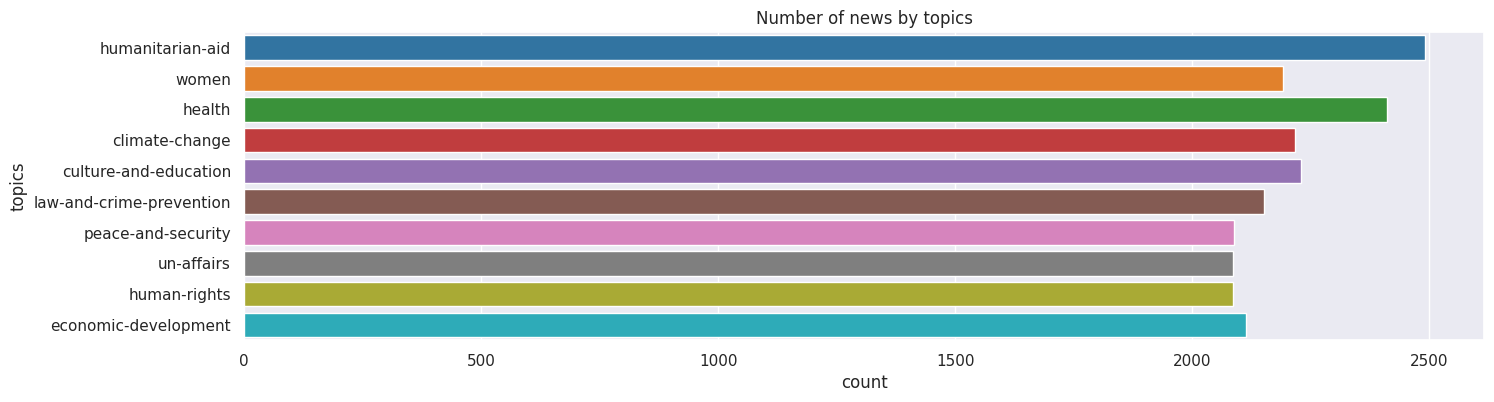

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df["topics"], palette="tab10", ax=ax)
plt.title("Number of news by topics");

Сама по себе дата как строка не является признаком, однако ее компоненты могут играть важную роль в работе модели. Поэтому мы преобразуем строковую дату в формат datetime и добавим к нашим признакам год, месяц и день недели.

In [ ]:
df["date"] = pd.to_datetime(df.date)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.strftime("%B")
df["weekday"] = df["date"].dt.strftime("%A")

Какие выводы можно сделать по графикам ниже:
- Все новости относятся к разным годам: с 2003 по 2023. Без пропусков.
- Больше всего новостей приходится на 2015 и 2022 года, а также на конец года - осень (Лидеры: Сентябрь и Октябрь). В течение недели больше всего новостей во вторник-четверг, хотя различия при исключении выходных не кажутся большими.
- Меньше всего новостей в первые годы (2003 - 2008), в выходные.

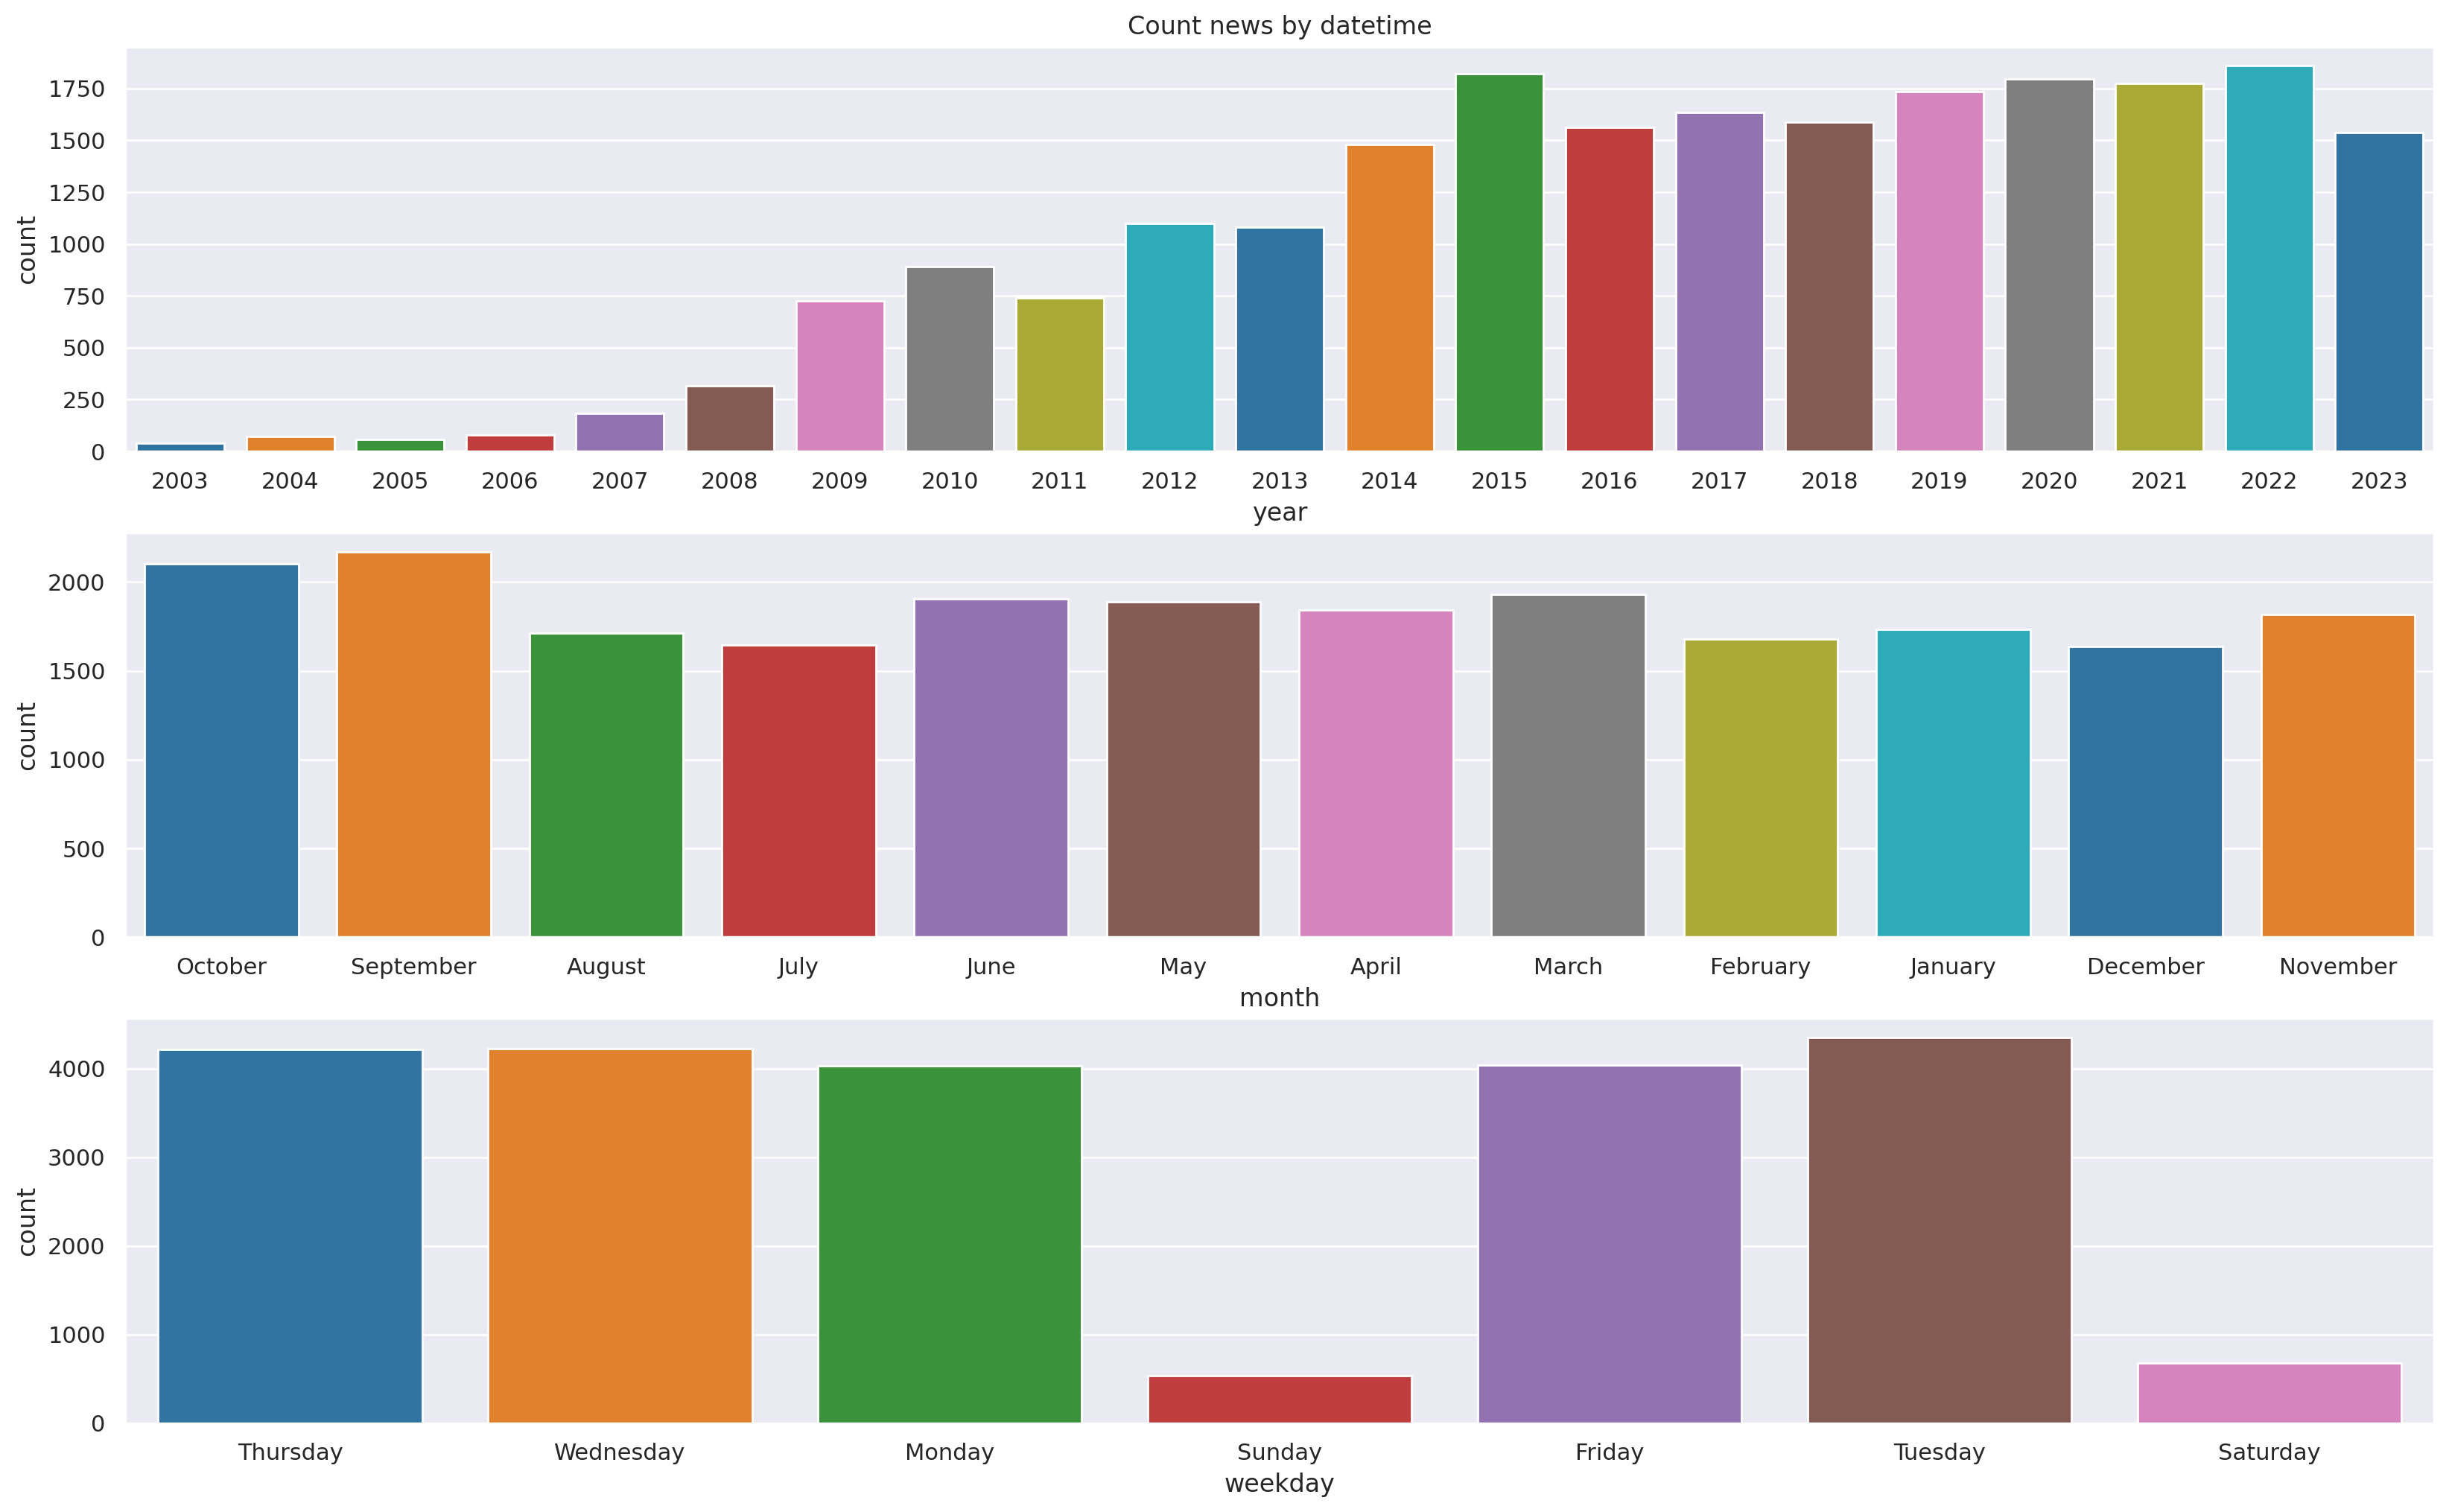

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind]
        # , order=df[col].value_counts(ascending=True).index
    )
axs[0].set_title("Count news by datetime");

Посчитаем длину заголовков, вступительного и основного текста.

In [ ]:
df["len_title"] = df["title"].str.len()
df["len_abstract"] = df["abstract"].str.len()
df["len_text"] = df["text"].str.len()

Посмотрим, как они выглядят в разрезе каждой категории.

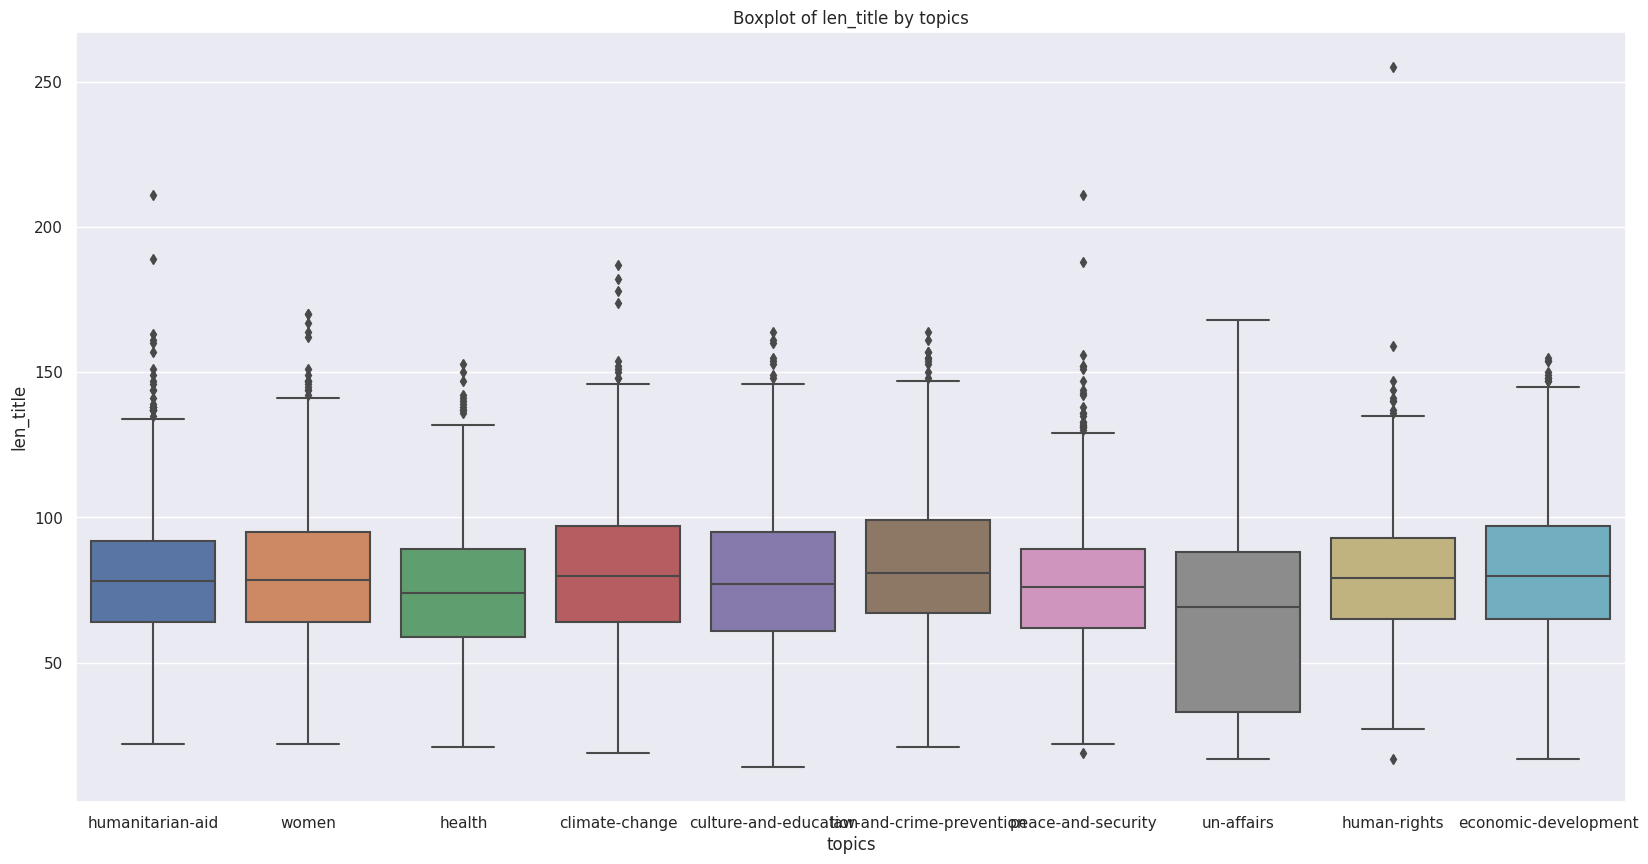

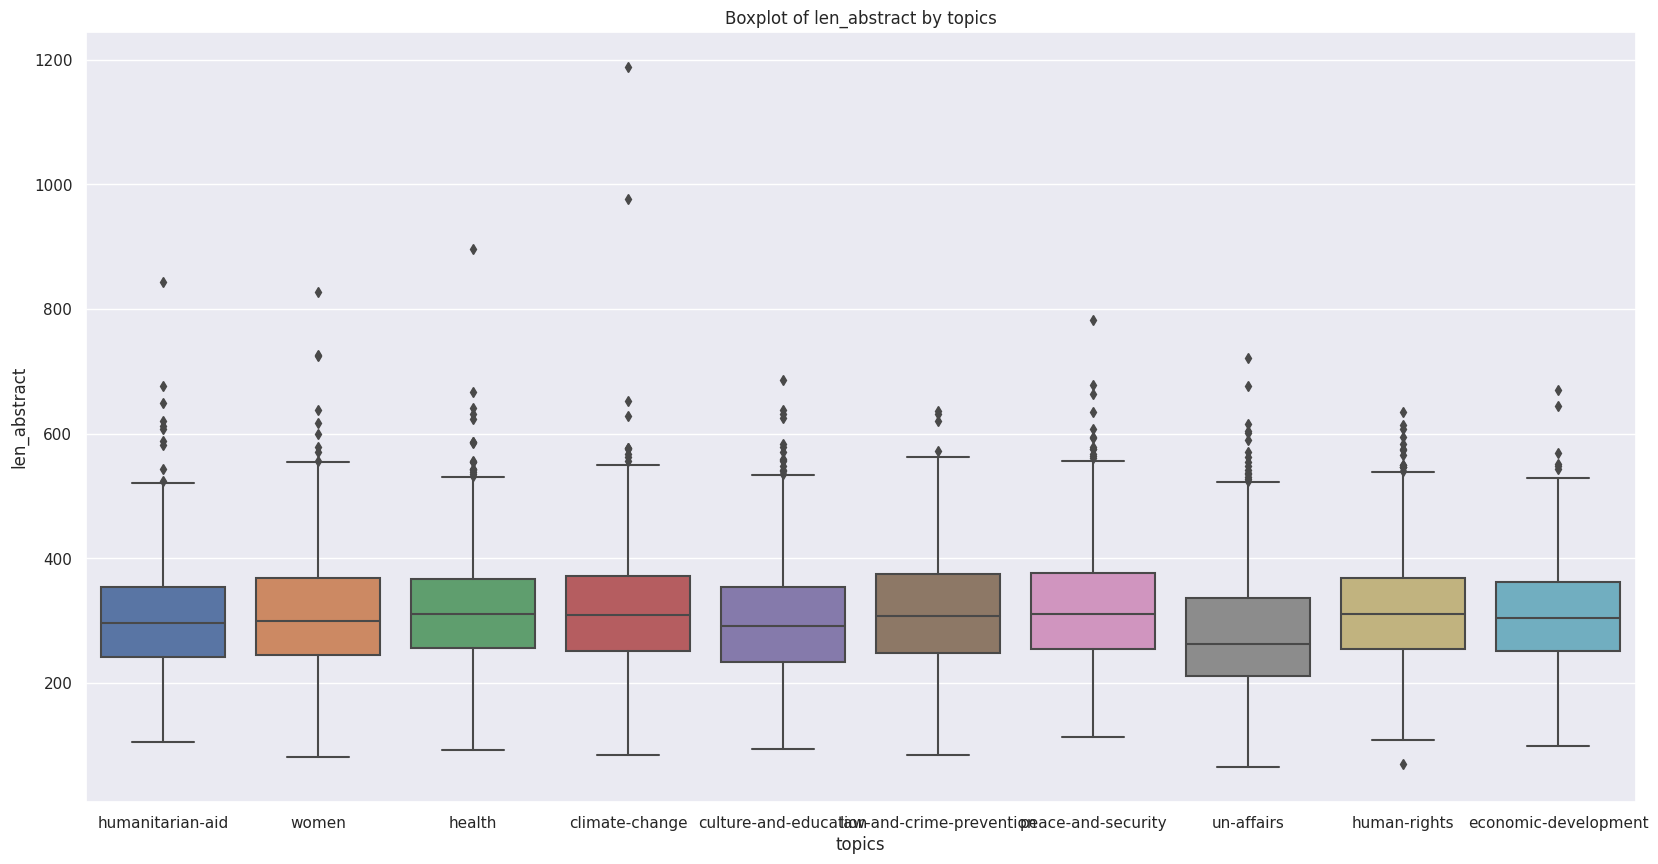

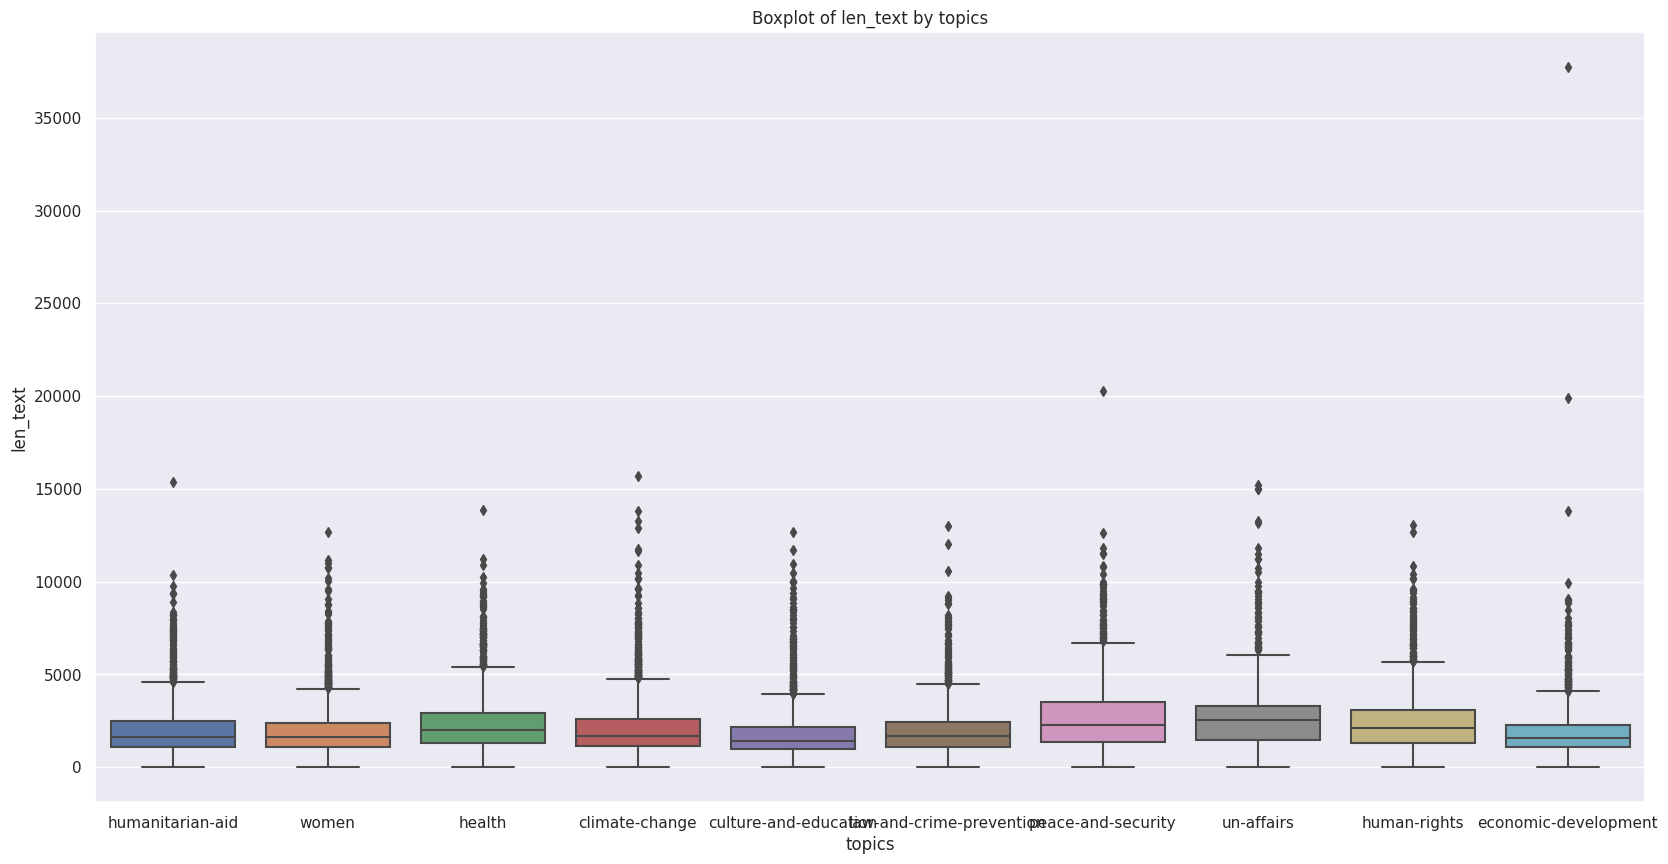

In [ ]:
for col in ["len_title", "len_abstract", "len_text"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topics", y=col, data=df, ax=ax)
    plt.title(f"Boxplot of {col} by topics");

Что можно заметить:
- В среднем длина заголовка по всем категориям около 65-70 символов
- Вступительный текст в среднем составляет 300 символов.
- Средняя длина основного текста варьирует чуть больше остальных параметров: примерно от 1500 до 2000 символов.
- Во всех параметрах и для всех категорий наблюдается большое количество заметные выбросов в сторону большего количества символов.

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [ ]:
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

In [ ]:
for topic in df.topics.unique():
    words = df[df.topics == topic].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

Output hidden; open in https://colab.research.google.com to view.

На сайте отсутствует счетчик просмотров или возможность комментирования. Но все равно ради интереса можно посмотреть распределение возраста статей. Тем более, что размах возрастов в нашем случае очень широк - от дня до 20 лет.

In [ ]:
df["lifetime"] = df["date"].apply(
    lambda x: (datetime.datetime.now() - x).total_seconds()
)
df["lifetime"] = df["lifetime"].apply(lambda x: divmod(x, 60)[0])  # lifetime in minutes

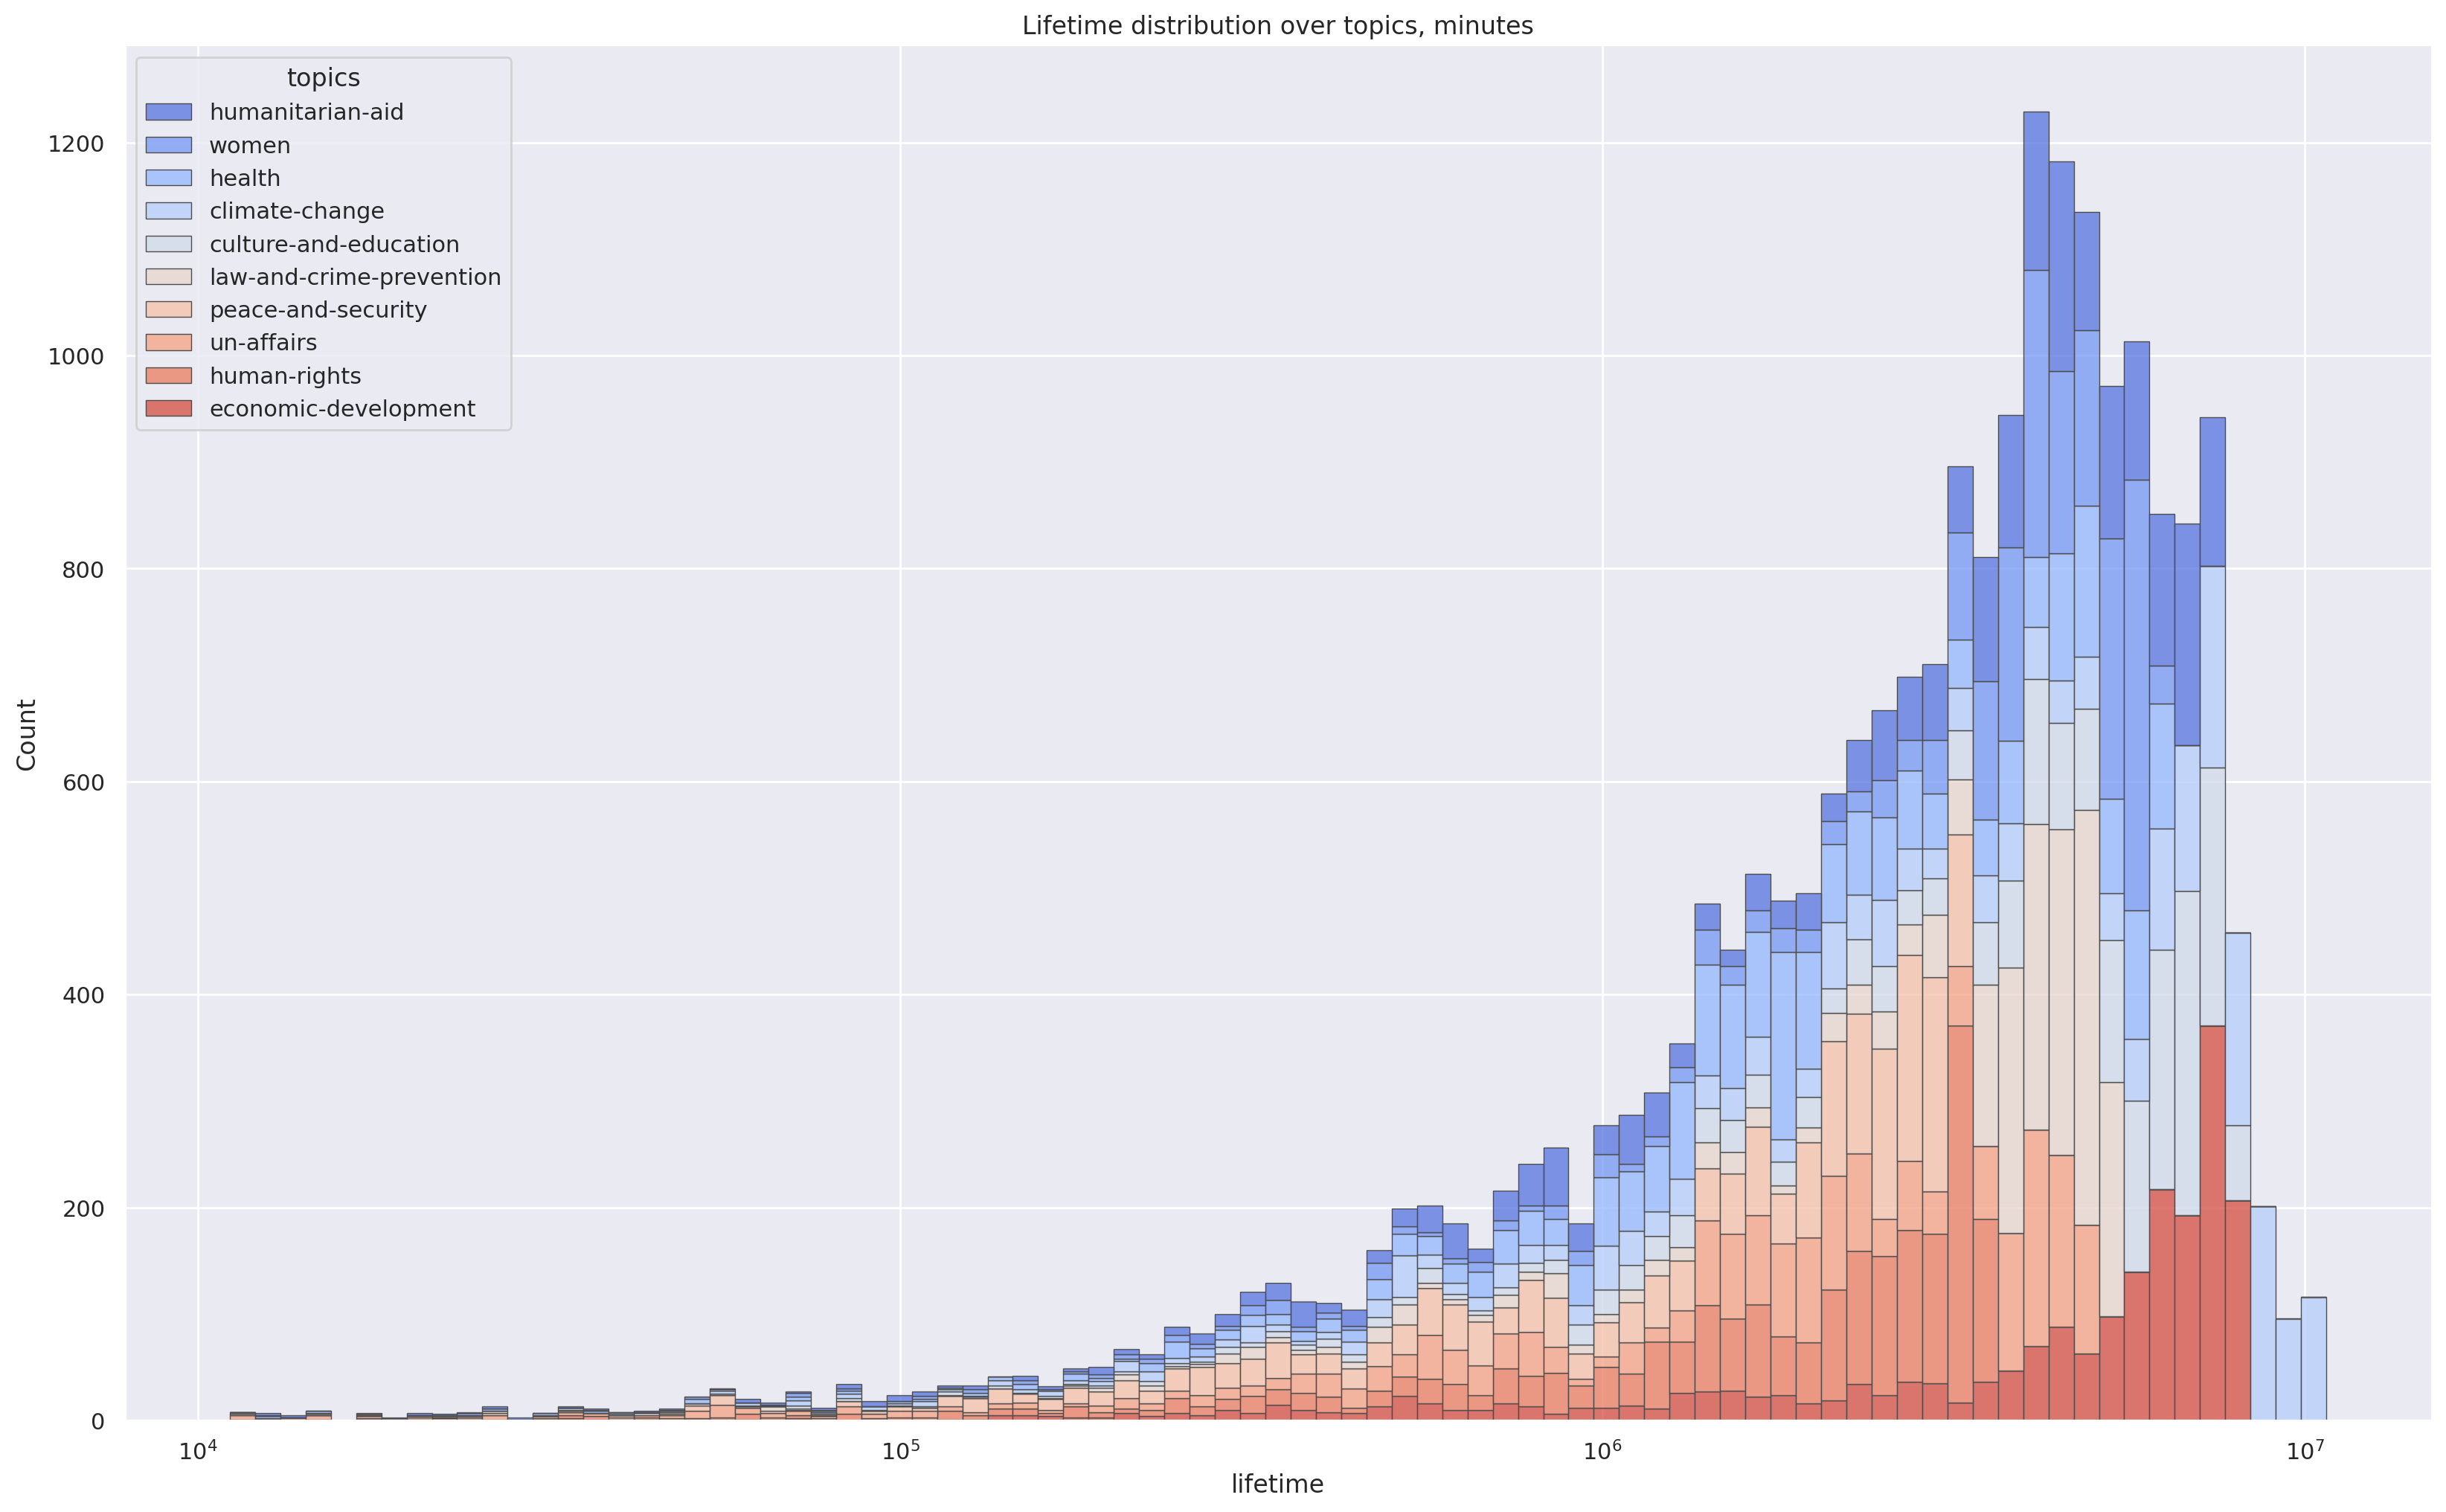

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="topics",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=0.5,
    log_scale=True,
)
axs.set_title("Lifetime distribution over topics, minutes");

В датасете присутствуют как старые статьи, так и новые. И само распределение имеет смещённое вправо распределение.
Стоит отметить, что разные категории имеют разное количество статей, публикуемых в год. Это отражается не только на распределении возраста, но и на выборке в целом. Для некотрых категорий статьи в целом моложе, чем у категорий, в которых статьи публикуются реже.

Обработаем доступные нам текстовые поля.

### Выводы

Итак, на данном этапе мы провели первичный анализ датасета. Статьи распределены по тематикам равномерно. Все новости относятся к временному диапозону от 2003 до 2023 года. Максимум статей приходится на 2017 год. Больше всего новостей пишется в Сентябре и Октябре. По дням недели на текущих данных меньше всего новостей выходит в выходные и больше всего в середине недели, хотя различия в рабочую неделю небольшие.

В среднем длина заголовка по всем категориям около 65-70 символов. Длина вступительного текста в среднем составляет в среднем 300 символов. Длина основного текста варьирует больше и в среднем примерно составляет 1500-2000 символов. Все перечисленные текстовые признаки в каждой категории имели большое количество выбросов в сторону больших значений.

Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

Поскольку мы работаем с текстами, на этом этапе пока не столь очевидно, какие данные и по какой причине стоит считать выбросами, а какие - особенностями конкретной тематики. Поэтому это мы оставим на следующие этапы работы над проектом.

## Часть 2. Векторизация текста и построение моделей

In [ ]:
!pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 96.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=ed1ac3d933af30ece27b26fa37921373533c3336a0c82b3b851467b2c567d982
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26094 sha256=304e3a84739bc295673f546c591fdc978bbdba846ee85fa5c20bf89a73a7d3e1
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


In [ ]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
RND_STATE = 73

### Предобработка текста
Чтобы получить более точное и компактное представление текстов, обычно делают нормализацию текста, которая включает в себя следующие этапы:
- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

Для нас совершенно не важен регистр текста, его род и падеж, а также различные символы, которые и вовсе текстом не являются.

Таким образом, мы ожидаем, что после предобработки текста качество модели должно возрасти.

Существуют разные библиотеки для обработки текста, мы будем использовать Наташу, потому что она включяет в себя все необходимые нам элементы предобработки (токенизация и лемматизация), а также [демонстрирует сравнительно хорошее качество](https://github.com/natasha/naeval) при работе с русским языком.

In [ ]:
# Стоп-слова
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "комментарий",
        "английский",
        "язык",
    ]
)

In [ ]:
df = pd.read_pickle("df_topics.p", compression="gzip")

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

Напишем функцию, которая будет осуществлять всю указанную выше предобработку текста.

In [ ]:
def text_prep(text) -> str:
    doc = Doc(text)  # Преобразуем текст в объект класса документ
    doc.segment(segmenter)  # Сегментация
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:  # Токенизация
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]  # Лемматизация
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [ ]:
%%time
df["title_clean"] = df.title.apply(text_prep)
df["abstract_clean"] = df.abstract.apply(text_prep)
df["text_clean"] = df.text.apply(text_prep)

CPU times: user 36min 57s, sys: 21min 13s, total: 58min 10s
Wall time: 34min 35s


In [ ]:
# Сохранение датасета с обработанным текстом
df.to_pickle("df_topics_clean.p", compression="gzip")

In [ ]:
# Извлечение заранее сохраненного датасета с обработанным текстом
df = pd.read_pickle("df_topics_claen.p", compression="gzip")

Посмотрим, насколько разумно работает наша предобработка, оценив качество преобразования текстовых данных.

In [ ]:
# Заголовок
df.sample(1)[["title", "title_clean"]].values

array([['Давос: главный правозащитник ООН о роли бизнеса в борьбе с дискриминацией ЛГБТИ',
        'давос главный правозащитник оон роль бизнес борьба дискриминация лгбти']],
      dtype=object)

In [ ]:
# Вступительный текст
df.sample(1)[["abstract", "abstract_clean"]].values

array([['Во Всемирную метеорологическую организацию (ВМО) поступили сообщения\xa0 о том,\xa0 что в минувшую\xa0 субботу, 20 июня, в российском городе Верхоянске, расположенном за Полярным кругом, температура воздуха достигла рекорда – плюс 38 градусов по Цельсию.\xa0\n',
        'всемирный метеорологический организация вмо поступить сообщение минувший суббота июнь российский город верхоянск расположить полярный круг температура воздух достигнуть рекорд плюс градус цельсий']],
      dtype=object)

In [ ]:
# Основной текст
df.sample(1)[["text", "text_clean"]].values

array([['Эта позитивная тенденция – результат работы по охране «птичьих» маршрутов, как это предусмотрено Африканско-Евразийским договором об охране водоплавающих птиц.\nДоговор призван защитить почти полмиллиарда водоплавающих птиц, обитающих вдоль африканско-евразийского пути миграции. Сегодня более 60 процентов популяций 220 видов, охраняемых в рамках договора, стабильны или увеличиваются. Растет «население» пеликанов, фламинго, цапель и многих других хорошо знакомых нам птиц. А вот число журавлей стремительно сокращается.\nУменьшаются и популяции других видов. В ООН связывают эту тенденции с сокращение с ухудшением состояния окружающей среды. Изменение климата влияет на водный режим многих заболоченных мест, где обитают эти виды пернатых.\nВ результате целые виды, казалось бы, распространенных по всему миру птиц оказываются под угрозой исчезновения намного быстрее, чем восстанавливаются их популяции. Главная причина этого явления -\xa0 потеря среды обитания вдоль миграционных путей

#### Word2Vec

Давайте теперь применим альтернативный подход к представлению слов - Word2Vec. Этот метод основывается на семантической близости слов. Построим модель на нашей выборке новостей.

In [ ]:
# Инициализируем и обучаем модель
model = Word2Vec(
    sentences=df.title_clean.str.split(),
    vector_size=300,
    min_count=10,
    window=2,
    seed=RND_STATE,
)

Посмотрим, насколько разумные у нас получились вектора.

In [ ]:
model.wv.most_similar(positive=["вакцина"])

[('туберкулез', 0.9933038949966431),
 ('коронавирус', 0.9916785955429077),
 ('болезнь', 0.991465151309967),
 ('человечность', 0.9911728501319885),
 ('полиомиелит', 0.9907221794128418),
 ('вакцинация', 0.9906639456748962),
 ('детский', 0.9906578660011292),
 ('эпидемия', 0.990510880947113),
 ('неинфекционный', 0.9904009699821472),
 ('период', 0.9902830123901367)]

В целом все логично: близкие вектора - это воктора слов, обозначающих болезни и связанные с ними слова.

In [ ]:
model.wv.most_similar(positive=["женщина"])

[('иметь', 0.9431506395339966),
 ('сексуальный', 0.9139625430107117),
 ('условие', 0.9127172231674194),
 ('должный', 0.9096492528915405),
 ('отношение', 0.9058111310005188),
 ('возможность', 0.9013209342956543),
 ('пожилой', 0.8982930183410645),
 ('девочка', 0.8978065848350525),
 ('лишить', 0.8877593278884888),
 ('стать', 0.8840382695198059)]

Это выглядит чуть менее логичным, но объяснимо с точки зрения контекста. Вероятно это связано с наличием тематики о женщинах, в которую входят статьи о дискриминации в отношении женщин. К примеру, слова "учиться" и "ребенок" связаны с женщинами через контекст дискрминации в области образования и поражениями в репродуктивных и родительских правах.

In [ ]:
model.wv.most_similar(positive=["право"])

[('нарушение', 0.8798362612724304),
 ('защита', 0.8042459487915039),
 ('безопасность', 0.7814721465110779),
 ('торговля', 0.7643956542015076),
 ('продлить', 0.7588314414024353),
 ('член', 0.7564437389373779),
 ('обсудить', 0.7427683472633362),
 ('управлять', 0.7367339730262756),
 ('ситуация', 0.7346370220184326),
 ('пожилой', 0.7278589010238647)]

Видим, что все выглядит отчасти логично.

Чтобы построить модель, нам нужно получить вектора для предложения. Это можно сделать двумя способами:
- Усреднить вектора слов, входящих в предложение
- Взвесить вектора слов, входящих в предложение на основании их tf-idf весов

Важно заметить, что здесь легко совершить методологическую ошибку. Ранее мы обучали вектора на всей выборке, а теперь для валидации сделаем честный эксперимент и обучим только на тренировочной.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.text_clean.str.split(), df.topics.values, random_state=RND_STATE
)

model = Word2Vec(
    sentences=X_train, vector_size=200, min_count=10, window=2, seed=RND_STATE
)

#####Подход с Tf-Idf

In [ ]:
# Векторизация и преобразование векторов слов на основании их tf-idf весов
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""

    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()]
        )

        return self

    def transform(self, X):
        return np.array(
            [
                np.mean(
                    [
                        self.word2vec.get_vector(w) * self.word2weight[w]
                        for w in words
                        if w in self.word2vec
                    ]
                    or [np.zeros(self.dim)],
                    axis=0,
                )
                for words in X
            ]
        )

#####Подход с усреднением векторов

In [ ]:
# Векторизация и преобразование (усреднение) векторов слов
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""

    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array(
            [
                np.mean(
                    [self.word2vec.get_vector(w) for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)],
                    axis=0,
                )
                for words in X
            ]
        )

Для того, чтобы по-прежнему использовать `Pipeline`, оформим описанные выше подходы в классы.

###Логистическая регрессия

In [ ]:
# Построение модели
Log_Mean = Pipeline(
    [
        ("w2v", MeanEmbeddingVectorizer(model)),
        ("clf", LogisticRegression(random_state=RND_STATE, max_iter=1000)),
    ]
)

Log_Mean.fit(X_train, y_train)

print(classification_report(y_test, Log_Mean.predict(X_test)))

                          precision    recall  f1-score   support

          climate-change       0.66      0.73      0.69       536
   culture-and-education       0.54      0.48      0.51       566
    economic-development       0.53      0.55      0.54       515
                  health       0.66      0.72      0.69       571
            human-rights       0.43      0.50      0.47       549
        humanitarian-aid       0.61      0.66      0.63       621
law-and-crime-prevention       0.43      0.39      0.41       570
      peace-and-security       0.47      0.51      0.49       508
              un-affairs       0.46      0.39      0.42       539
                   women       0.38      0.30      0.33       542

                accuracy                           0.52      5517
               macro avg       0.52      0.52      0.52      5517
            weighted avg       0.52      0.52      0.52      5517



In [ ]:
y_pred = Log_Mean.predict(X_test)

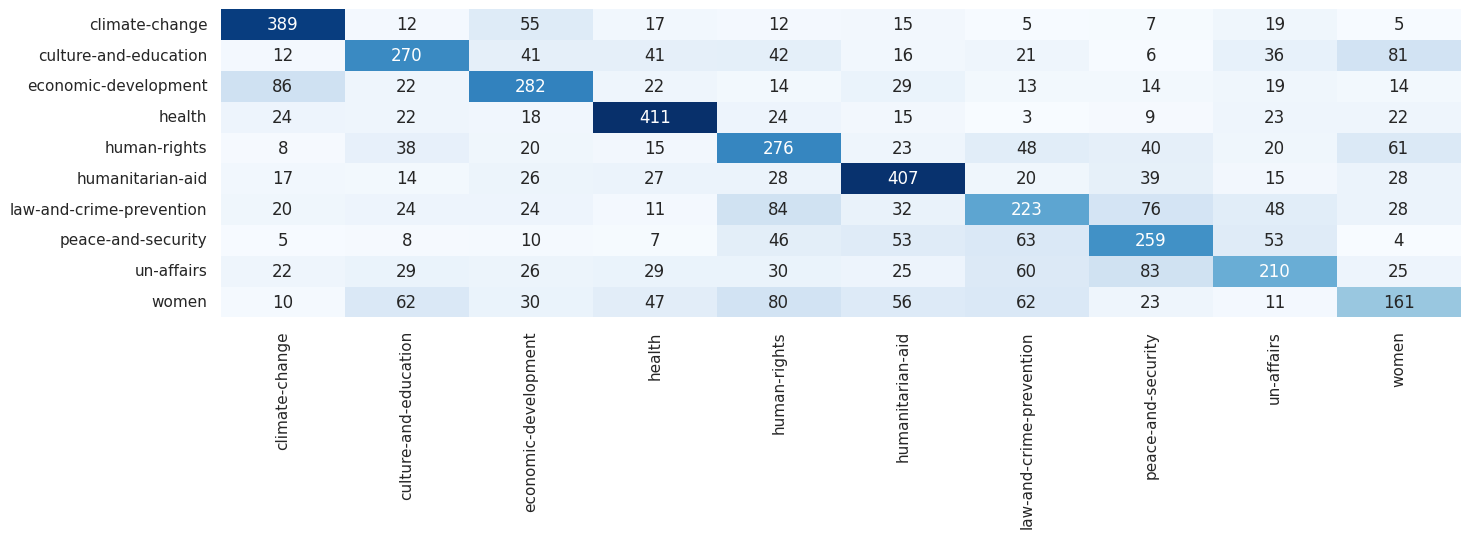

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=Log_Mean.classes_)

cm_df = pd.DataFrame(data=cm, columns=Log_Mean.classes_, index=Log_Mean.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

У нас получилась довольно низкие значения полноты и точности. Особенно это касается категории `women`. Результат сомнительный.

In [ ]:
# Построение модели
Log_Tf_Idf = Pipeline(
    [
        ("w2v", TfidfEmbeddingVectorizer(model)),
        ("clf", LogisticRegression(random_state=RND_STATE, max_iter=10000)),
    ]
)

Log_Tf_Idf.fit(X_train, y_train)

print(classification_report(y_test, Log_Tf_Idf.predict(X_test)))

                          precision    recall  f1-score   support

          climate-change       0.65      0.72      0.68       536
   culture-and-education       0.53      0.46      0.49       566
    economic-development       0.53      0.55      0.54       515
                  health       0.66      0.72      0.69       571
            human-rights       0.43      0.49      0.46       549
        humanitarian-aid       0.61      0.66      0.63       621
law-and-crime-prevention       0.42      0.39      0.40       570
      peace-and-security       0.48      0.53      0.50       508
              un-affairs       0.46      0.38      0.42       539
                   women       0.37      0.31      0.34       542

                accuracy                           0.52      5517
               macro avg       0.51      0.52      0.52      5517
            weighted avg       0.52      0.52      0.52      5517



Результаты примерно те же, с незначительными улучшениями. Категория `women` все еще хуже всех предсказывается. Попрбуем при последующих решениях задачи классификации использовать именно подход Tf-Idf.

In [ ]:
y_pred = Log_Tf_Idf.predict(X_test)

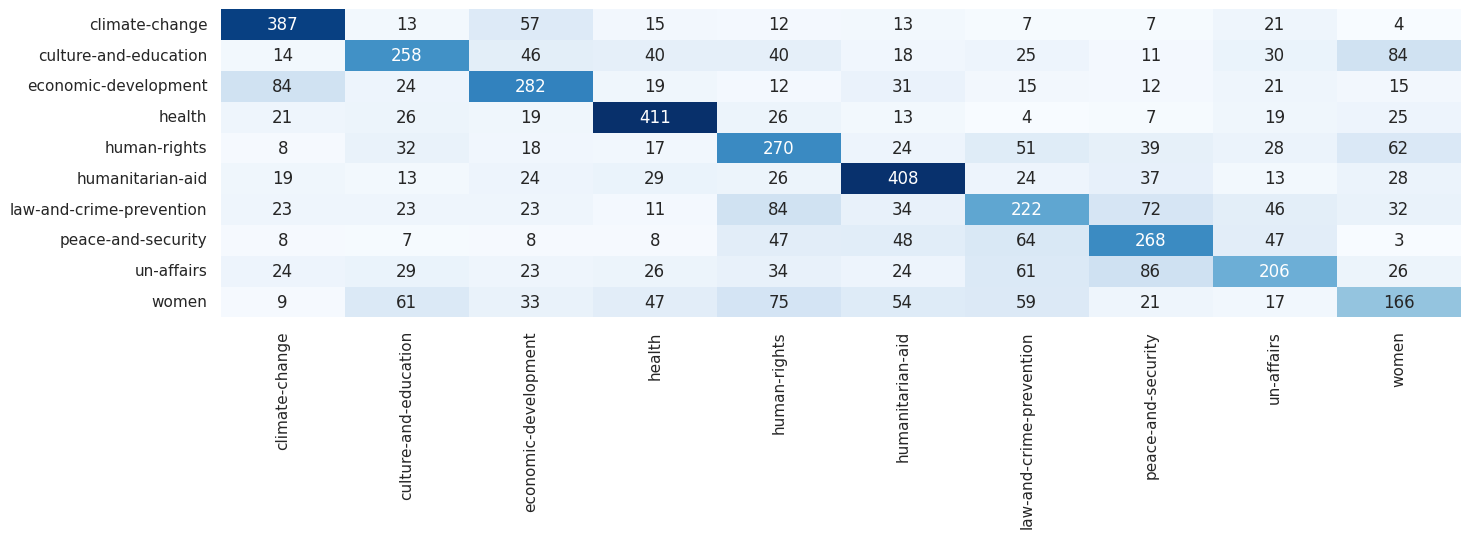

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=Log_Tf_Idf.classes_)

cm_df = pd.DataFrame(data=cm, columns=Log_Tf_Idf.classes_, index=Log_Tf_Idf.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

Примерно то же самое.

###Метод опорных векторов SVM

In [ ]:
# Построение модели
SVC_model = Pipeline(
    [
        ("w2v", TfidfEmbeddingVectorizer(model)),
        ("clf", SVC(random_state=RND_STATE, max_iter=10000)),
    ]
)

SVC_model.fit(X_train, y_train)

print(classification_report(y_test, SVC_model.predict(X_test)))

                          precision    recall  f1-score   support

          climate-change       0.65      0.76      0.70       536
   culture-and-education       0.60      0.48      0.53       566
    economic-development       0.54      0.55      0.54       515
                  health       0.68      0.74      0.71       571
            human-rights       0.46      0.51      0.48       549
        humanitarian-aid       0.60      0.71      0.66       621
law-and-crime-prevention       0.46      0.40      0.43       570
      peace-and-security       0.50      0.53      0.52       508
              un-affairs       0.54      0.54      0.54       539
                   women       0.40      0.28      0.33       542

                accuracy                           0.55      5517
               macro avg       0.54      0.55      0.54      5517
            weighted avg       0.55      0.55      0.55      5517



In [ ]:
y_pred = SVC_model.predict(X_test)

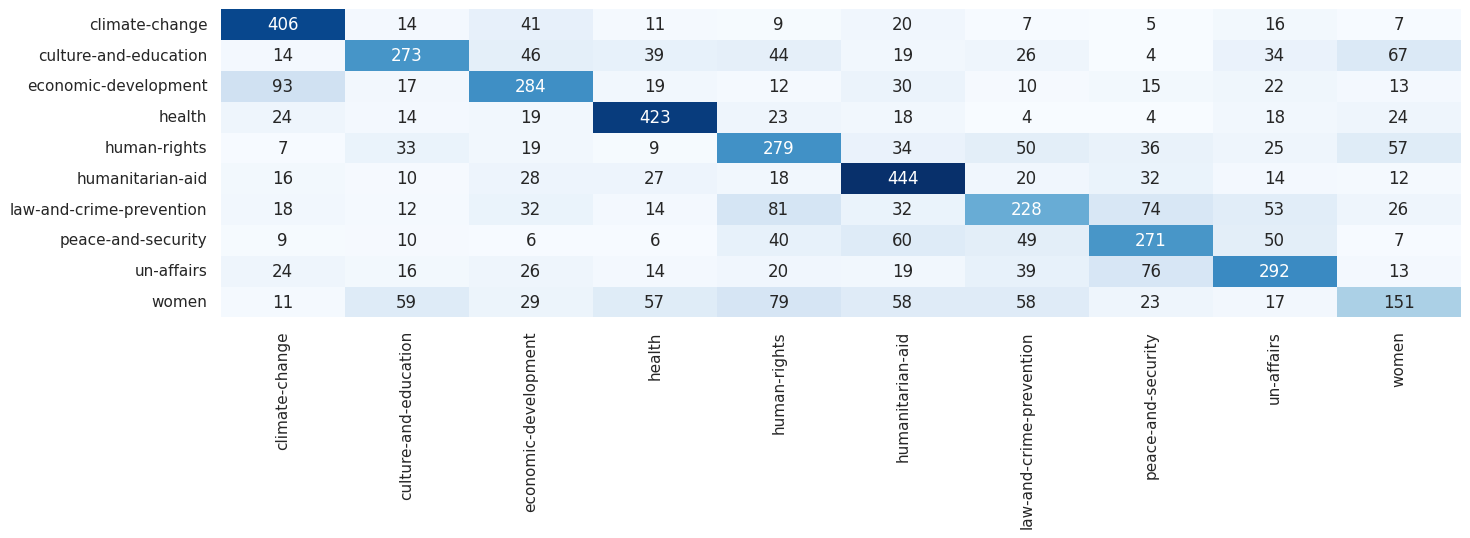

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=SVC_model.classes_)

cm_df = pd.DataFrame(data=cm, columns=SVC_model.classes_, index=SVC_model.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

Метод опорных екторов сработал чуть лучше логистической регрессии. Но тем не менее, модель все равно достаточно слабая.

###Наивный байесовский метод


In [ ]:
# Построение модели
from sklearn.naive_bayes import GaussianNB

Bayesian = Pipeline([("w2v", TfidfEmbeddingVectorizer(model)), ("clf", GaussianNB())])

Bayesian.fit(X_train, y_train)

print(classification_report(y_test, Bayesian.predict(X_test)))

                          precision    recall  f1-score   support

          climate-change       0.66      0.64      0.65       536
   culture-and-education       0.54      0.41      0.47       566
    economic-development       0.49      0.49      0.49       515
                  health       0.60      0.67      0.63       571
            human-rights       0.39      0.44      0.42       549
        humanitarian-aid       0.56      0.70      0.62       621
law-and-crime-prevention       0.37      0.37      0.37       570
      peace-and-security       0.39      0.40      0.39       508
              un-affairs       0.34      0.47      0.40       539
                   women       0.32      0.11      0.16       542

                accuracy                           0.47      5517
               macro avg       0.47      0.47      0.46      5517
            weighted avg       0.47      0.47      0.46      5517



In [ ]:
y_pred = Bayesian.predict(X_test)

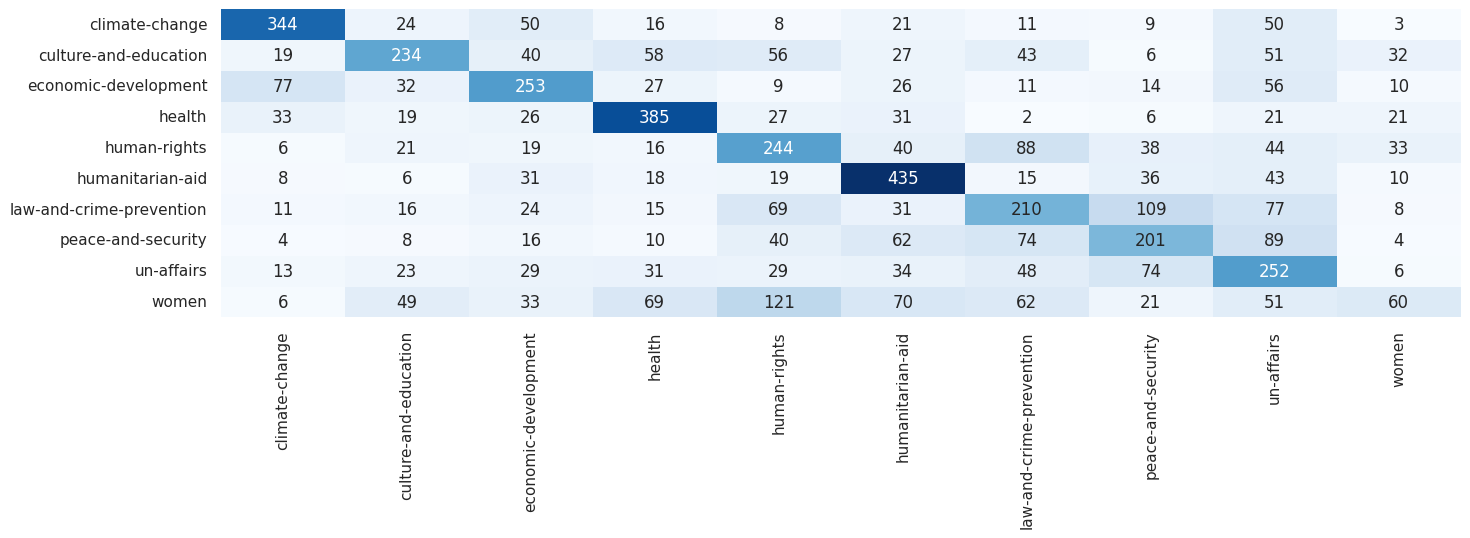

In [ ]:
# Построим для данной модели Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=Bayesian.classes_)

cm_df = pd.DataFrame(data=cm, columns=Bayesian.classes_, index=Bayesian.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap="Blues", fmt="d", cbar=False);

Опять всё плохо! Это худшая модель из всех.

###Выводы

Модели получались довольно слабыми. Это скорее всего связано со спецификой данных. Несмотря на то, что на новостном сайте ООН не указана множественная тегоизация статей (как и не показаны сами теги), она есть по факту. Одна и та же статья может фигурировать в рахных рубриках, что может очень сильно снизить предсказательную силу модели.
При проерки на дупликаты, было выяснено, что почти 9000 статей имели повторых и относились больше чем к одной категории (чаще к двум сразу). Несмотря на то, что повторы нами были удалены, само их наличие в таком большом количестве показывает сильное пересечение категорий по контексту. Помимо этого сами категории по теме довольно широки. К примеру, возьмем категорию `women` статьи по кторой могут пойти в раздел `human-rights`, `humanitarian-aid`, `health` (слово "женщины" фигурирует также в облаках слов данных категорий) и т.д. - не зря именно категория `women` хуже остальных предсказывается моделями.

PS: Помимо всего прочего, как я уже упоминал, нигде не сказано, что статья может относиться к нескольким категориям. Я выяснил это лишь после анализа - модели там были, ясное дело, еще хуже. Так что теперь я усвоил важный урокЖ проверять на датасет на дубликаты ДО долгого анализа :)

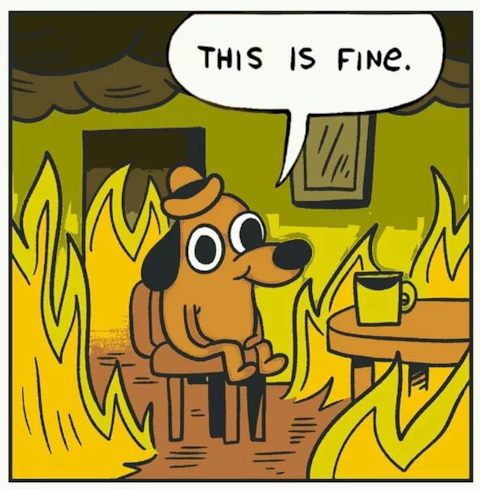